# Reference

-   [FRED](https://fred.stlouisfed.org/searchresults/?st=ICE%20BofA)
-   [Gemini](https://gemini.google.com/app/a0cd28b75b80675e?utm_source=app_launcher&utm_medium=owned&utm_campaign=base_all)
-   [Gemini](https://gemini.google.com/app/0da10f614b7e7434?utm_source=app_launcher&utm_medium=owned&utm_campaign=base_all)


# MSCI Kokusai Constituents Macro Factor Model Ver2

## 回帰モデル

$$
R_i - R_f = \alpha
+ \beta_{\mathrm{mkt}}(R_{\mathrm{mkt}} - R_f)
+ \left[\beta_{\mathrm{level}}F_{\mathrm{level}}
+ \beta_{\mathrm{slope}}F_{\mathrm{slope}}
+ \beta_{\mathrm{curvature}}F_{\mathrm{curvature}}\right]
+ \beta_{X}F_{X}
+ \beta_{\mathrm{Inflation}}F_{\mathrm{Inflation}}
+ \epsilon_{i}
$$

-   $R_i$: 個別銘柄リターン
-   $R_f$: リスクフリーレート（米国 3 ヶ月物財務省短期証券 TBill）、日次リターン計測用。FRED シリーズは`DTB3`。長期の場合は 10 年物財務省長期証券を使用。
    -   年率ベースであるため、日次に変換。
-   $\beta_{\mathrm{mkt}}$: マーケット(MSCI Kokusai)ベータ。リスクフリーレートからの指数の超過収益を使う。

### 金利ベータ

-   $\beta_{\mathrm{level}}$: US 金利データを主成分分析したのちの第 1 主成分(level)によるベータ
-   $\beta_{\mathrm{slope}}$: 第 2 主成分(slope)によるベータ
-   $\beta_{\mathrm{curvature}}$: 第 3 主成分(curvature)によるベータ

### クレジット orVIX ベータ: $\beta_{X}$

次の 1 または 2 を使用。

1.  $\beta_{\mathrm{FtoQ}}$: Flight to Quality ファクターによるベータ。

    定義は米国ハイイールド債スプレッド（FRED シリーズ:`BAMLH0A0HYM2` ）と米国投資適格級スプレッド（FRED シリーズ`BAMLC0A0CM`）の差分。"質への逃避"をモデル化したもの。このファクターが拡大する時、安全な投資適格債に比べて、リスクの高いハイイールド債を極端に避けている（+より高いリスクプレミアムを要求している）ことを意味する。これは市場の恐怖感を抽出したファクターとなりうる。

    企業の倒産リスクをどれだけ深刻に捉えているかを直接反映する。実際の売買の**行動の結果**が FtoQ ファクターに現れる。また、リスクの識別・選別という情報を含み、単にリスクオフになっているだけでなく、**質の低い社債が質の高い社債に比べてどれだけ余計に売られているか**を定量化している。

2.  $\beta_{\mathrm{VIX}}$: VIX 指数によるベータ。FRED シリーズは`VIXCLS`。

    S&P 500 の株価が将来どれだけ大きく変動するかという市場予想を反映する。これは企業の信用リスクだけでなく、地政学リスクや政治不安といった不確実性にも反応する。VIX は将来の変動を予想してプットオプションなどを買う行動の結果である。よって VIX が FtoQ に先行して急騰することもある。

### インフレベータ

-   $\beta_{\mathrm{Inflation}}$: インフレファクターベータ。5 年または 10 年ブレークイーブン・インフレ率を使う。
    -   FRED シリーズは`T5YIE`（5 年） or `T10YIE`（10 年）。

### 直行化

[Google Document を参照](https://docs.google.com/document/d/1OJ1hipUb0jYnwNXVZmq4FhBTmOqx0nSz0VpI-uF8PRQ/edit?tab=t.0)


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import polars as pl
from pathlib import Path
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MultipleLocator
import statsmodels.api as sm
import seaborn as sns
import json
import os
import sys
from sklearn.decomposition import PCA
from dotenv import load_dotenv
from dateutil.relativedelta import relativedelta
from datetime import datetime, date, timedelta
from typing import List
from fredapi import Fred
from tqdm import tqdm
from data_check_utils import calculate_missing_stats, extract_dates_in_range
from database_utils import (
        get_table_names,
        step1_load_file_to_db,
        step2_create_variable_tables,
        step3_create_return_table
    )
from make_factor import orthogonalize
from data_prepare import createDB_bpm_and_factset_code
from concurrent.futures import ThreadPoolExecutor

import warnings

warnings.simplefilter("ignore")


Q_DIR = Path().cwd().parent.parent
DATA_DIR = Q_DIR / "data" / "MSCI_KOKUSAI"
PRJ_DIR = Q_DIR / "A_001"
# Factset Benchmark directory
BM_DIR = Q_DIR / "data/Factset/Benchmark"
FRED_DIR = Path().cwd().parents[2] / "FRED"
print(f"FRED directory: {FRED_DIR}")


fred_module = str((FRED_DIR / "src").resolve())
if fred_module not in sys.path:
    sys.path.append(fred_module)
    print(f"{fred_module}をsys.pathに追加しました。")

from fred_database_utils import (
        store_fred_database,
        get_fred_ids_from_file,
        load_data_from_database,
    )
from us_treasury import (
        plot_us_interest_rates_and_spread,
        analyze_yield_curve_pca,
        plot_loadings_and_explained_variance,
        load_yield_data_from_database,
    )

FRED_API = os.getenv("FRED_API_KEY")

# Prepare FRED Data
series_id_list = get_fred_ids_from_file(FRED_DIR / "fred_series.json")
db_path = FRED_DIR / "FRED.db"
store_fred_database(db_path=db_path, series_id_list=series_id_list, FRED_API=FRED_API)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
FRED directory: /Users/yukihata/Desktop/papers-1/FRED
--- FREDデータの差分更新を開始 (データベース: 'FRED.db') ---
テーブル 'SP500' は存在しません。新規に作成します。
	FREDシリーズ 'SP500' を取得中 (開始日: 全期間)...
	シリーズ 'SP500' をテーブルとして新規保存しました (2609 件)。
テーブル 'CPIAUCSL' は存在しません。新規に作成します。
	FREDシリーズ 'CPIAUCSL' を取得中 (開始日: 全期間)...
	シリーズ 'CPIAUCSL' をテーブルとして新規保存しました (943 件)。
テーブル 'DFF' の最終日: 2025-08-21 00:00:00。これ以降のデータを取得します。
	FREDシリーズ 'DFF' を取得中 (開始日: 2025-08-22)...
	シリーズ 'DFF' に 4 件の新規データを追加しました。
テーブル 'FEDFUNDS' は存在しません。新規に作成します。
	FREDシリーズ 'FEDFUNDS' を取得中 (開始日: 全期間)...
	シリーズ 'FEDFUNDS' をテーブルとして新規保存しました (853 件)。
テーブル 'SOFR' は存在しません。新規に作成します。
	FREDシリーズ 'SOFR' を取得中 (開始日: 全期間)...
	シリーズ 'SOFR' をテーブルとして新規保存しました (1930 件)。
テーブル 'DPRIME' は存在しません。新規に作成します。
	FREDシリーズ 'DPRIME' を取得中 (開始日: 全期間)...
	シリーズ 'DPRIME' をテーブルとして新規保存しました (18274 件)。
テーブル 'DTB3' は存在しません。新規に作成します。
	FREDシリーズ 'DTB3' を取得中 (開始日: 全期間)...
	シリーズ 'DTB3' をテーブルとして新規保存しました (18691 件)。
テーブル 'DGS1MO' の最終日

## Prepare Data


### Return data


#### MSCI Kokusai Constituents


In [ ]:
db_path = DATA_DIR / "MSCI_KOKUSAI_Price_Daily.db"
conn = sqlite3.connect(db_path)
return_secs = pd.read_sql(
    "SELECT * FROM FG_PRICE_Daily ORDER BY date", con=conn, parse_dates=["date"]
).assign(log_value=lambda row: np.log(row["value"]))
return_secs["Return"] = return_secs.groupby("P_SYMBOL")["log_value"].diff()
return_secs = return_secs[["date", "P_SYMBOL", "Return"]].dropna(
    how="any", ignore_index=True
)
display(return_secs)


,date,P_SYMBOL,Return
0,2005-08-23,0HSW-GB,-0.009018
1,2005-08-23,0II3.XX1-GB,-0.000887
2,2005-08-23,0MDJ-GB,0.002397
3,2005-08-23,0N1N-GB,-0.005587
4,2005-08-23,0N3I-GB,-0.012804
...,...,...,...
11207574,2025-08-25,ZION-US,0.000895
11207575,2025-08-25,ZM-US,-0.013674
11207576,2025-08-25,ZS-US,-0.010532
11207577,2025-08-25,ZTS-US,-0.009172


#### MSCI Kokusai Index


In [ ]:
db_path = BM_DIR / "BM_Price_Daily.db"
conn = sqlite3.connect(db_path)
return_index = (
    pd.read_sql(
        "SELECT * FROM FG_PRICE_Daily WHERE P_SYMBOL='MSCI Kokusai Index (World ex Japan)' ORDER BY date",
        con=conn,
        parse_dates=["date"],
    )
    .assign(log_value=lambda row: np.log(row["value"]))
    .assign(Return=lambda row: row["log_value"].diff())
    .dropna(ignore_index=True)
)[["date", "P_SYMBOL", "Return"]]
conn.close()
display(return_index)


,date,P_SYMBOL,Return
0,2005-08-26,MSCI Kokusai Index (World ex Japan),-0.004817
1,2005-08-29,MSCI Kokusai Index (World ex Japan),0.002335
2,2005-08-30,MSCI Kokusai Index (World ex Japan),-0.003790
3,2005-08-31,MSCI Kokusai Index (World ex Japan),0.012329
4,2005-09-01,MSCI Kokusai Index (World ex Japan),0.008984
...,...,...,...
5025,2025-08-19,MSCI Kokusai Index (World ex Japan),-0.003922
5026,2025-08-20,MSCI Kokusai Index (World ex Japan),-0.001473
5027,2025-08-21,MSCI Kokusai Index (World ex Japan),-0.003438
5028,2025-08-22,MSCI Kokusai Index (World ex Japan),0.014586


### Calculate Excess Return


In [ ]:
db_path = FRED_DIR / "FRED.db"
conn = sqlite3.connect(db_path)
risk_free_rate = pd.read_sql(
    "SELECT * FROM DTB3", con=conn, parse_dates=["date"]
).assign(
    DTB3=lambda row: row["DTB3"].div(252 * 100)
)  # convert to daily data
conn.close()
print("Risk free rate(DTB3)")
display(risk_free_rate)


excess_return_secs = (
    pd.merge(return_secs, risk_free_rate, on=["date"], how="left")
    .dropna(how="any", ignore_index=True)
    .assign(Excess_Return=lambda row: row["Return"].sub(row["DTB3"]))
)
print("Excess return of securities")
display(excess_return_secs)


excess_return_index = (
    pd.merge(return_index, risk_free_rate, on=["date"], how="left")
    .dropna(how="any", ignore_index=True)
    .assign(Factor_Market=lambda row: row["Return"].sub(row["DTB3"]))
)
print("Excess return of MSCI Kokusai Index")
display(excess_return_index)


Risk free rate(DTB3)


,date,DTB3
0,1954-01-04,0.000053
1,1954-01-05,0.000051
2,1954-01-06,0.000051
3,1954-01-07,0.000052
4,1954-01-08,0.000052
...,...,...
18686,2025-08-19,0.000163
18687,2025-08-20,0.000163
18688,2025-08-21,0.000164
18689,2025-08-22,0.000163


Excess return of securities


,date,P_SYMBOL,Return,DTB3,Excess_Return
0,2005-08-23,0HSW-GB,-0.009018,0.000137,-0.009155
1,2005-08-23,0II3.XX1-GB,-0.000887,0.000137,-0.001025
2,2005-08-23,0MDJ-GB,0.002397,0.000137,0.002260
3,2005-08-23,0N1N-GB,-0.005587,0.000137,-0.005725
4,2005-08-23,0N3I-GB,-0.012804,0.000137,-0.012942
...,...,...,...,...,...
10954956,2025-08-25,ZION-US,0.000895,0.000163,0.000732
10954957,2025-08-25,ZM-US,-0.013674,0.000163,-0.013836
10954958,2025-08-25,ZS-US,-0.010532,0.000163,-0.010694
10954959,2025-08-25,ZTS-US,-0.009172,0.000163,-0.009335


Excess return of MSCI Kokusai Index


,date,P_SYMBOL,Return,DTB3,Factor_Market
0,2005-08-26,MSCI Kokusai Index (World ex Japan),-0.004817,0.000138,-0.004955
1,2005-08-29,MSCI Kokusai Index (World ex Japan),0.002335,0.000138,0.002197
2,2005-08-30,MSCI Kokusai Index (World ex Japan),-0.003790,0.000137,-0.003928
3,2005-08-31,MSCI Kokusai Index (World ex Japan),0.012329,0.000137,0.012193
4,2005-09-01,MSCI Kokusai Index (World ex Japan),0.008984,0.000135,0.008849
...,...,...,...,...,...
4988,2025-08-19,MSCI Kokusai Index (World ex Japan),-0.003922,0.000163,-0.004085
4989,2025-08-20,MSCI Kokusai Index (World ex Japan),-0.001473,0.000163,-0.001637
4990,2025-08-21,MSCI Kokusai Index (World ex Japan),-0.003438,0.000164,-0.003602
4991,2025-08-22,MSCI Kokusai Index (World ex Japan),0.014586,0.000163,0.014423


### Interest Rate Factor

#### 金利変動幅に対して PCA(Leve, Slope, Curvature)


tenor,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,3.22,NaN,3.70,3.88,NaN,4.06,4.07,NaN
1962-01-03,NaN,NaN,NaN,3.24,NaN,3.70,3.87,NaN,4.03,4.07,NaN
1962-01-04,NaN,NaN,NaN,3.24,NaN,3.69,3.86,NaN,3.99,4.06,NaN
1962-01-05,NaN,NaN,NaN,3.26,NaN,3.71,3.89,NaN,4.02,4.07,NaN
1962-01-08,NaN,NaN,NaN,3.31,NaN,3.71,3.91,NaN,4.03,4.08,NaN


tenor,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
date,,,,,,,,,,,
2025-08-19,4.46,4.30,4.11,3.91,3.75,3.70,3.82,4.04,4.30,4.89,4.90
2025-08-20,4.45,4.30,4.11,3.90,3.74,3.69,3.81,4.02,4.29,4.86,4.89
2025-08-21,4.49,4.32,4.14,3.95,3.79,3.75,3.86,4.07,4.33,4.89,4.92
2025-08-22,4.47,4.27,4.08,3.87,3.68,NaN,3.76,3.98,4.26,4.84,4.88
2025-08-25,4.45,4.29,4.08,3.88,3.73,NaN,3.80,4.01,4.28,4.86,4.89


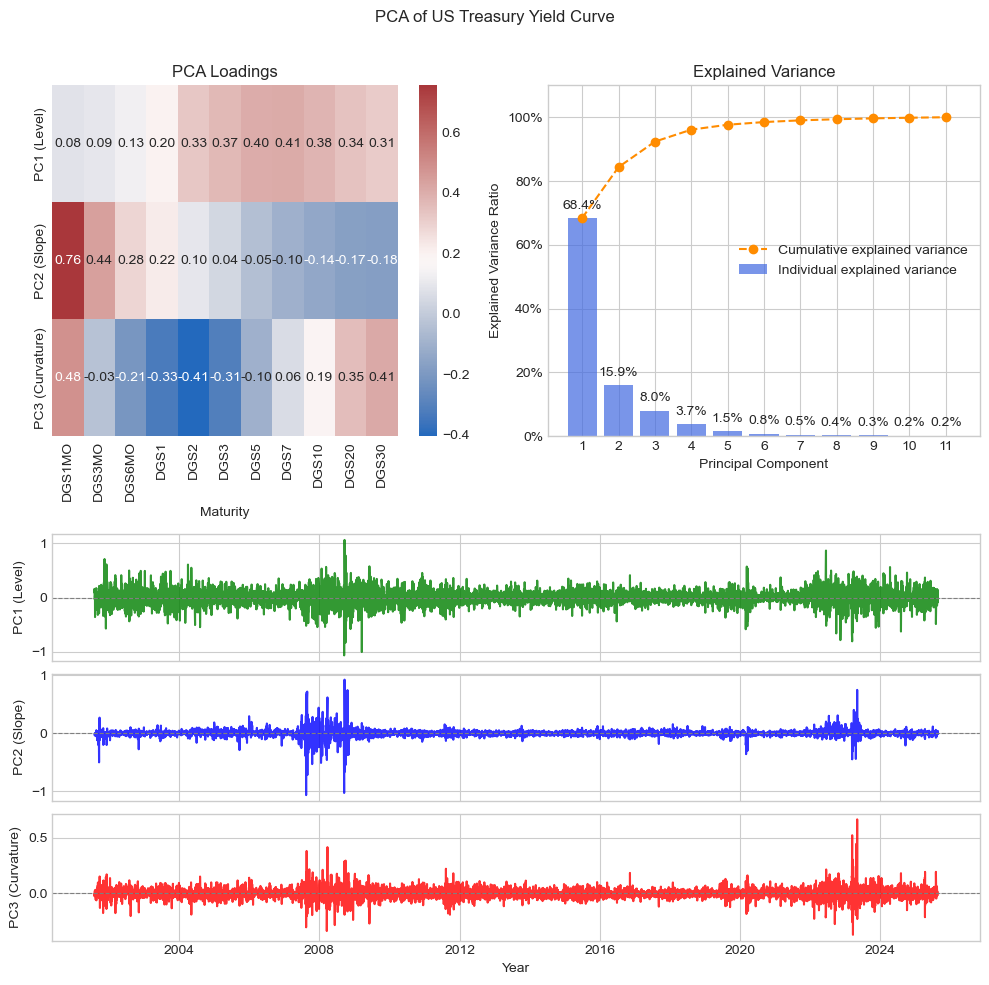

,PC1,PC2,PC3,Level_Shock,Slope_Shock,Curvature_Shock
date,,,,,,
2001-08-02,0.160171,-0.025849,-0.007925,0.066597,0.000625,0.016766
2001-08-03,0.069691,-0.026974,-0.016009,-0.090479,-0.001124,-0.008084
2001-08-06,-0.037518,-0.012564,0.025388,-0.107210,0.014410,0.041397
2001-08-07,0.034438,0.004281,-0.000375,0.071956,0.016844,-0.025763
2001-08-08,-0.360821,-0.006097,0.028950,-0.395259,-0.010377,0.029325
...,...,...,...,...,...,...
2025-08-15,0.092732,-0.019953,0.021076,-0.063614,-0.051762,0.026495
2025-08-18,0.028580,0.003660,-0.003417,-0.064151,0.023613,-0.024494
2025-08-19,-0.092685,-0.010806,-0.007848,-0.121266,-0.014466,-0.004430


In [ ]:
db_path = FRED_DIR / "FRED.db"
df_yield = load_yield_data_from_database(db_path=db_path)
display(df_yield.head())
display(df_yield.tail())

# Check: loading and contribution
plot_loadings_and_explained_variance(df_yield=df_yield)

# PCA and PCA Shock
df_pca, pca = analyze_yield_curve_pca(df_yield=df_yield)
df_pca = df_pca.assign(
    Level_Shock=lambda row: row["PC1"].diff(),
    Slope_Shock=lambda row: row["PC2"].diff(),
    Curvature_Shock=lambda row: row["PC3"].diff(),
).dropna()
display(df_pca)


### Flight to Quality Factor and Inflation Factor


In [ ]:
# Flight to Quality Factor
db_path = FRED_DIR / "FRED.db"
df_FtoQ = load_data_from_database(
    db_path=db_path, series_id_list=["BAMLH0A0HYM2", "BAMLC0A0CM"]
)
df_FtoQ = (
    pd.pivot(df_FtoQ, index="date", columns="variable", values="value")
    .sort_index()
    .assign(FtoQ=lambda row: row["BAMLH0A0HYM2"].sub(row["BAMLC0A0CM"]))
    .assign(FtoQ_Shock=lambda row: row["FtoQ"].diff())
).dropna(how="any")[["FtoQ_Shock"]]
display(df_FtoQ)

# Inflation Factor
df_Inflation = (
    load_data_from_database(db_path=db_path, series_id_list=["T10YIE"])
    .set_index("date")
    .assign(Inflation_Shock=lambda row: row["value"].diff())
    .dropna()
)[["Inflation_Shock"]]
display(df_Inflation)


variable,FtoQ_Shock
date,
1997-01-03,0.02
1997-01-06,0.01
1997-01-07,0.00
1997-01-08,-0.02
1997-01-09,0.04
...,...
2025-08-19,0.01
2025-08-20,0.03
2025-08-21,0.01


,Inflation_Shock
date,
2003-01-03,-0.02
2003-01-06,0.01
2003-01-07,-0.01
2003-01-08,0.09
2003-01-09,0.07
...,...
2025-08-20,0.00
2025-08-21,0.04
2025-08-22,0.02


### 直行化


In [ ]:
df_factor = excess_return_index.copy().set_index("date")[["Factor_Market"]]
df_factor = pd.merge(
    df_factor,
    df_pca[["Level_Shock", "Slope_Shock", "Curvature_Shock"]],
    left_index=True,
    right_index=True,
)
df_factor = pd.merge(df_factor, df_FtoQ, left_index=True, right_index=True)
df_factor = pd.merge(
    df_factor, df_Inflation, left_index=True, right_index=True
).dropna()
# display(df_factor)

# 金利ファクター直行化
df_factor["Factor_Level"] = orthogonalize(
    df_factor["Level_Shock"], df_factor["Factor_Market"]
)
df_factor["Factor_Slope"] = orthogonalize(
    df_factor["Slope_Shock"], df_factor["Factor_Market"]
)
df_factor["Factor_Curvature"] = orthogonalize(
    df_factor["Curvature_Shock"], df_factor["Factor_Market"]
)

# FtoQファクター直行化: マーケットと金利ファクターに対して直行化
regressors_ftoq = df_factor[
    ["Factor_Market", "Factor_Level", "Factor_Slope", "Factor_Curvature"]
]
df_factor["Factor_FtoQ"] = orthogonalize(
    df_factor["FtoQ_Shock"], regressors=regressors_ftoq
)

# インフレファクター直行化: マーケット、金利ファクター、FtoQファクターに対して直行化
regressors_inflation = df_factor[
    ["Factor_Market", "Factor_Level", "Factor_Slope", "Factor_Curvature", "Factor_FtoQ"]
]
df_factor["Factor_Inflation"] = orthogonalize(
    df_factor["Inflation_Shock"], regressors=regressors_inflation
)

df_factor = df_factor[
    [
        "Factor_Market",
        "Factor_Level",
        "Factor_Slope",
        "Factor_Curvature",
        "Factor_FtoQ",
        "Factor_Inflation",
    ]
].dropna(how="any")
display(df_factor)

# ファクター間の相関行列
print("=== Correlation Matrix ===")
display(df_factor.corr().round(4))


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
date,,,,,,
2005-08-26,-0.004955,0.104003,0.017054,-0.014576,-0.043907,0.009278
2005-08-29,0.002197,-0.089192,0.022993,0.046783,0.027170,0.022500
2005-08-30,-0.003928,-0.123040,-0.078603,0.033028,0.068968,0.053375
2005-08-31,0.012193,-0.292230,0.059154,-0.011187,0.207413,-0.063300
2005-09-01,0.008849,0.264369,-0.174519,0.074223,0.102836,0.026472
...,...,...,...,...,...,...
2025-08-15,-0.001426,-0.057399,-0.051575,0.026983,-0.002832,-0.008156
2025-08-18,-0.000926,-0.059804,0.023740,-0.024142,-0.010656,0.003168
2025-08-19,-0.004085,-0.105116,-0.013961,-0.003217,-0.020471,-0.023804


=== Correlation Matrix ===


,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
Factor_Market,1.0,0.0000,-0.0000,-0.0000,0.0,0.0
Factor_Level,0.0,1.0000,-0.0144,0.0618,-0.0,0.0
Factor_Slope,-0.0,-0.0144,1.0000,0.0097,-0.0,-0.0
Factor_Curvature,-0.0,0.0618,0.0097,1.0000,0.0,0.0
Factor_FtoQ,0.0,-0.0000,-0.0000,0.0000,1.0,0.0
Factor_Inflation,0.0,0.0000,-0.0000,0.0000,0.0,1.0


In [ ]:
security = "AAPL-US"
excess_return_security = excess_return_secs.loc[
    excess_return_secs["P_SYMBOL"] == security, ["date", "Excess_Return"]
].set_index("date")

display(excess_return_security)
df_data = pd.merge(
    excess_return_security,
    df_factor,
    left_index=True,
    right_index=True,
)
display(df_data)


,Excess_Return
date,
2005-08-26,-0.007109
2005-08-29,0.002046
2005-08-30,0.015662
2005-08-31,0.006711
2005-09-01,-0.013662
...,...
2025-08-19,-0.001594
2025-08-20,-0.020095
2025-08-21,-0.005088


,Excess_Return,Factor_Market,Factor_Level,Factor_Slope,Factor_Curvature,Factor_FtoQ,Factor_Inflation
date,,,,,,,
2005-08-26,-0.007109,-0.004955,0.104003,0.017054,-0.014576,-0.043907,0.009278
2005-08-29,0.002046,0.002197,-0.089192,0.022993,0.046783,0.027170,0.022500
2005-08-30,0.015662,-0.003928,-0.123040,-0.078603,0.033028,0.068968,0.053375
2005-08-31,0.006711,0.012193,-0.292230,0.059154,-0.011187,0.207413,-0.063300
2005-09-01,-0.013662,0.008849,0.264369,-0.174519,0.074223,0.102836,0.026472
...,...,...,...,...,...,...,...
2025-08-15,-0.005289,-0.001426,-0.057399,-0.051575,0.026983,-0.002832,-0.008156
2025-08-18,-0.003191,-0.000926,-0.059804,0.023740,-0.024142,-0.010656,0.003168
2025-08-19,-0.001594,-0.004085,-0.105116,-0.013961,-0.003217,-0.020471,-0.023804
